In [1]:
import sys
import numpy as np
import pandas as pd
from scipy import special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize as NormColor
from tqdm import tqdm
import emcee
import corner
sys.path.append(".")
import HOD
from astropy.cosmology import Planck15
cosmo = Planck15 #FlatLambdaCDM(H0=67.74, Om0=0.3089, Tcmb0=2.725)
h = cosmo.H(0).value/100

/var/folders/wk/scnpc33x3q348qw83nb1tcgw0000gn/T/ipykernel_75181/3809700242.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


########################
ACF_new_parameters_z5.5.txt
########################


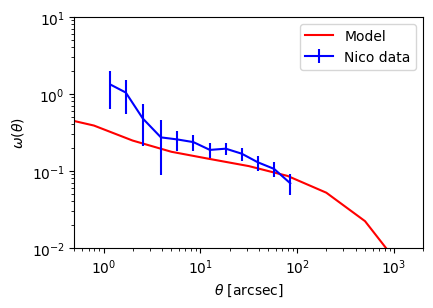

########################
ACF_new_parameters_z6.5.txt
########################


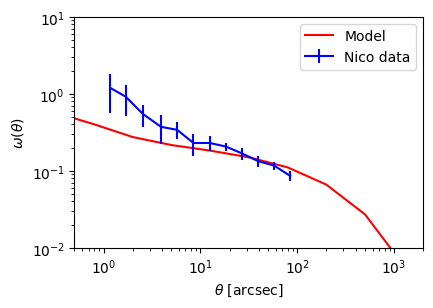

########################
ACF_new_parameters_z7.4.txt
########################


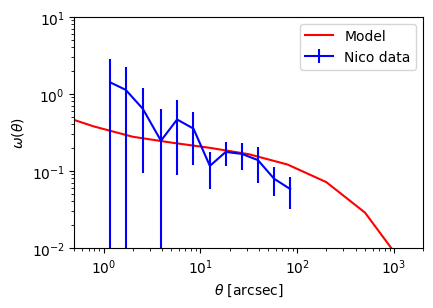

########################
ACF_new_parameters_z8.5.txt
########################


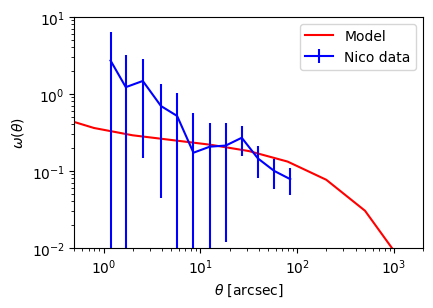

########################
ACF_new_parameters_z9.3.txt
########################


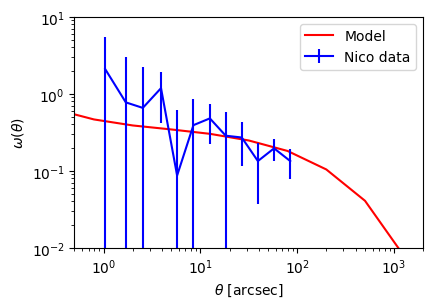

########################
ACF_new_parameters_z11.5.txt
########################


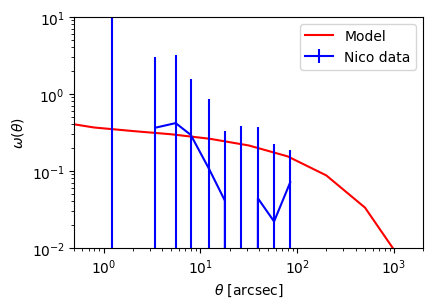

In [8]:
### Fit 2 halo ###
M_sat, M_min, sigma_logM, alpha = 10**11.5, 10**10.5, 0.2, 1.0
SHOW_HALO_TERMS = 1

def read_Nico_data(fname):
    data = pd.read_csv(fname, sep=' ')
    bin_centre = data['theta_bin'].to_numpy()
    w_obs = data['w_theta'].to_numpy()
    w_err = data['err_w_theta'].to_numpy()
    z_array = data['z_array'].to_numpy()
    Nz = data['Nz'].to_numpy()
    z_array, Nz = z_array[z_array>0], Nz[z_array>0]
    N_norm = Nz / (np.sum(Nz) * np.diff(z_array)[0])
    return bin_centre, w_obs, w_err, z_array, N_norm

fnames = ['ACF_new_parameters_z5.5.txt',
          'ACF_new_parameters_z6.5.txt',
          'ACF_new_parameters_z7.4.txt',
          'ACF_new_parameters_z8.5.txt',
          'ACF_new_parameters_z9.3.txt',
        #   'ACF_new_parameters_z10.6.txt',
          'ACF_new_parameters_z11.5.txt']

for fname, M_min, M_sat in zip(fnames,
                               np.power(10, np.array([11.25, 11.00, 10.75, 10.50, 10.25, 10.00])),
                               np.power(10, np.array([12.25, 12.20, 12.15, 12.10, 12.05, 12.00]))):
    print('########################')
    print(fname)
    print('########################')
    bin_centre, w_obs, w_err, z_array, N_norm = read_Nico_data('Data_Nico/'+fname)
    t_Nico = bin_centre/206265
    th_arr = np.logspace(-0.5, 3.5, 11)/206265
    # o2_N_allM = HOD.omega_2halo(t_Nico, M_min, sigma_logM, M_sat, alpha, N_norm, z_array,LOW_RES=1)
    o2_N = HOD.omega_2halo(th_arr, M_min, sigma_logM, M_sat, alpha, N_norm, z_array,
                           LOW_RES=1, mag_min = -22.3, mag_max = -15.5)
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 3), sharex=False, sharey=False)
    ax.plot(th_arr*206265, o2_N, c = 'r', ls = '-', label='Model')
    # ax.plot(th_arr*206265, o2_N_allM, c = 'c', ls = '-', label='All M')
    ax.errorbar(bin_centre,w_obs, w_err, c='b', label='Nico data')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim((0.5,2e3))
    ax.set_ylim((1e-2, 1e1))
    ax.set_xlabel(r'$\theta$ [arcsec]')
    ax.set_ylabel(r'$\omega$($\theta$)')
    plt.legend()
    plt.show()

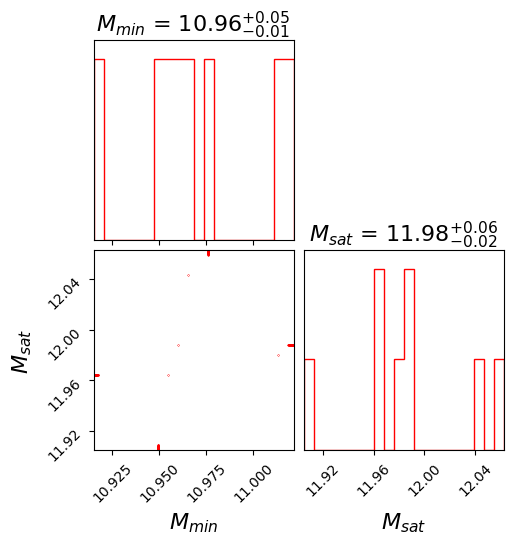

In [4]:
### PLOT CHAINS ###
__CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    quantiles=[0.5], #quantiles=[0.16, 0.5, 0.84],
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    # show_titles=True,
    max_n_ticks=6,
)

def get_samples(filepath):
    reader = emcee.backends.HDFBackend(filepath)
    if 0:
        tau = reader.get_autocorr_time(tol=0)
        burnin = int(2 * np.max(tau))
        thin = int(0.5 * np.min(tau))
        samples = reader.get_chain(discard=burnin, thin=thin)
    else:
        samples = reader.get_chain()
    return np.concatenate(samples, axis=0)


labels = [r'$M_{min}$', r'$M_{sat}$']
CORNER_KWARGS = dict(
    smooth=0.1,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    #quantiles=[0.16, 0.5, 0.84],
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=True,
    #max_n_ticks=3,
)

Z_OBSERVATION = 5.5
MCMC_z5 = get_samples('chains_2halo_z'+str(Z_OBSERVATION)+'.h5')
fig = corner.corner(MCMC_z5, color='r', labels=labels, **CORNER_KWARGS)
plt.show()